In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
import json

In [3]:
# Load data from json
with open("PNL_data.json") as json_file:
    PNL_data = json.load(json_file)

with open("POL_data.json") as json_file:
    POL_data = json.load(json_file)

# Combine and mark with up or down
combined = \
    [(event, 2 * (1 + (ix % 5))) for ix, event in enumerate(PNL_data["data"])] + \
    [(event, -2 * (1 + (ix % 5))) for ix, event in enumerate(POL_data["data"])]

# Split into labels
def to_datetime(stamp: str):
    return datetime.strptime(stamp, '%a, %d %b %Y %H:%M:%S GMT')

times = [to_datetime(event["timestamp"]) for (event, _) in combined]
labels = [event["event"] for (event, _) in combined]
levels = [level for (_, level) in combined]

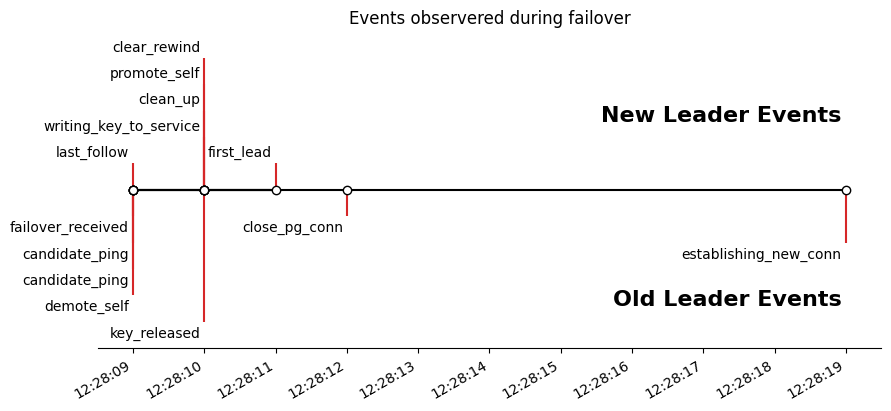

In [11]:
# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), layout="constrained")
ax.set(title="Events observered during failover")

ax.vlines(times, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(times, np.zeros_like(times), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(times, levels, labels):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

# format x-axis with 4-month intervals
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Hand draw above/below labels for clarity
ax.annotate("New Leader Events", xy=(times[-1], 6),
                xytext=(-3,4), textcoords="offset points",
                weight="bold",
                fontsize=16,
                horizontalalignment="right",
                verticalalignment="top")

ax.annotate("Old Leader Events", xy=(times[-1], -8),
                xytext=(-3,4), textcoords="offset points",
                weight="bold",
                fontsize=16,
                horizontalalignment="right",
                verticalalignment="top")

# remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()